In [1]:
!pip install statsmodels

In [2]:
##STEP 1 : IMPORTING ALL THE NECESSARY LIBRARIES
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf 
from sklearn.metrics import root_mean_squared_error 

In [3]:
##STEP 2 : SETTING UP THE DATAFRAME
time_df = pd.read_csv('airline_passenger_timeseries.csv')
time_df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
time_df.shape

(144, 2)

In [5]:
time_df['Month'].value_counts()

Month
1949-01    1
1949-02    1
1949-03    1
1949-04    1
1949-05    1
          ..
1960-08    1
1960-09    1
1960-10    1
1960-11    1
1960-12    1
Name: count, Length: 144, dtype: int64

In [6]:
##OBSERVATION: This means we have unique data for each day, no duplicate data present

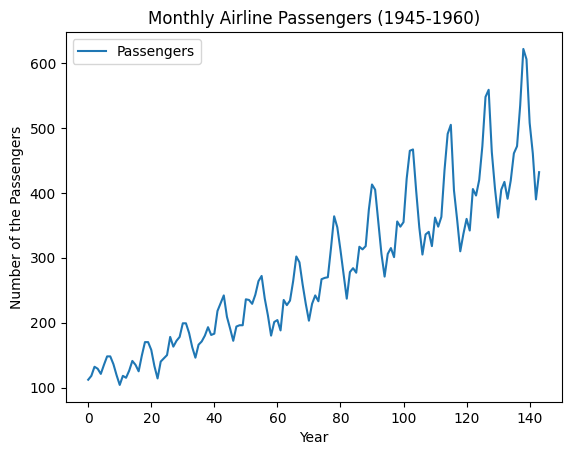

In [7]:
##STEP 3 : EDA AND VISUALIZATIONS
time_df.plot()
plt.xlabel('Year')
plt.ylabel('Number of the Passengers')
plt.title('Monthly Airline Passengers (1945-1960)')
plt.show()


In [8]:
##OBSERVATION : There is an upward trend. There's a peak every year that means a thers is a clear annual pattern.

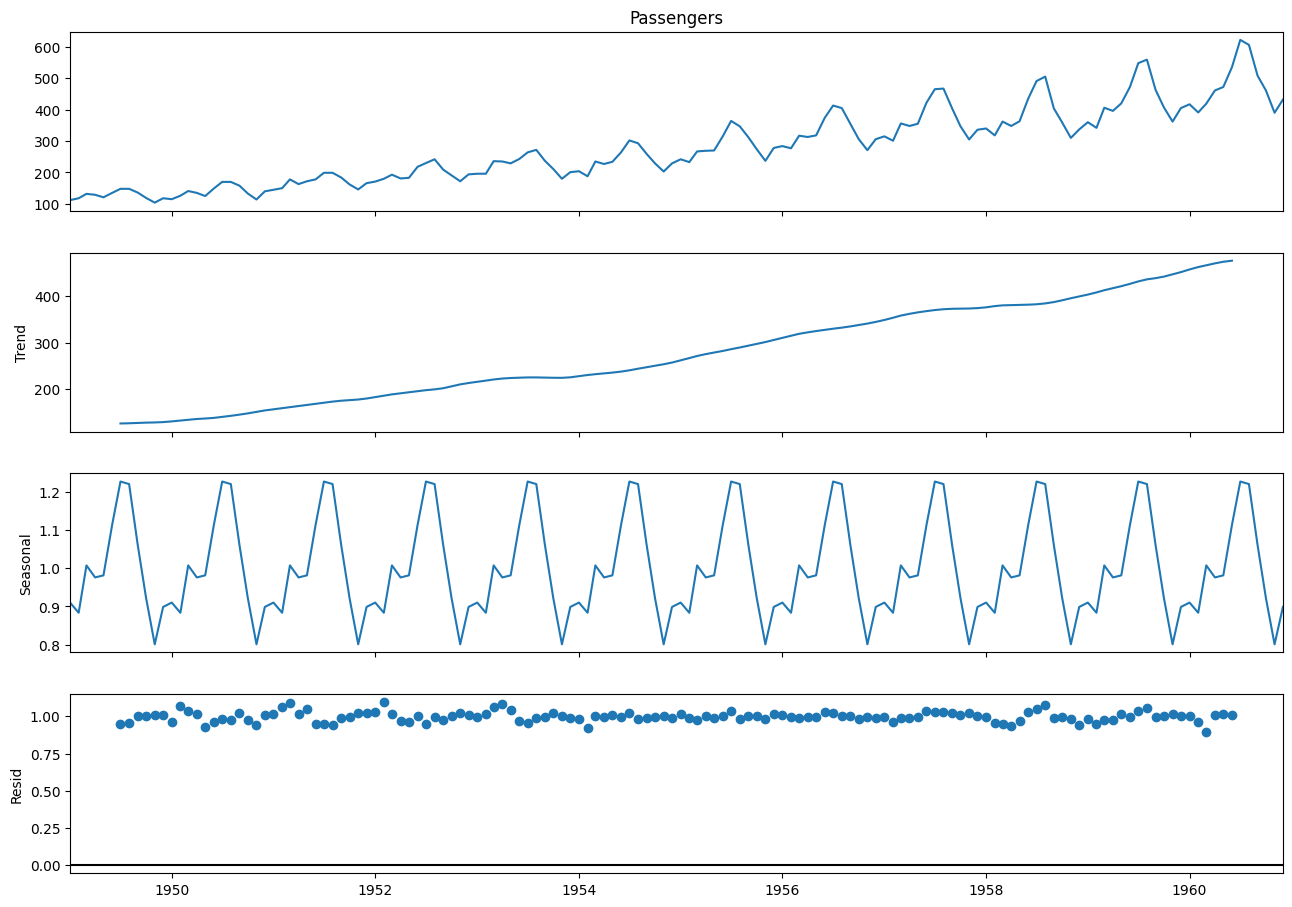

In [9]:
time_df['Month'] = pd.to_datetime(time_df['Month'])
time_df.set_index('Month',inplace=True)

decomposition = sm.tsa.seasonal_decompose(time_df['Passengers'],model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(14,10)
plt.show()

In [10]:
##STEP 4 : TEST STATIONARITY (means the mean,variance,autocorrelation are constant over time)
def test_stationarity(timeseries):
    time_dftest = adfuller(timeseries,autolag='AIC')
    time_dfoutput = pd.Series(time_dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in time_dftest[4].items():
        time_dfoutput['Critical Value (%s)' %key] = value
    
    print(time_dfoutput)
    
test_stationarity(time_df['Passengers'])

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [11]:
##OBSERVATION : Visualy we can see the data was non-statsionary.Mathematically, ADF test has given p-value is very high that means we accept the NUll HYPOTHESIS (Data is not stationary)

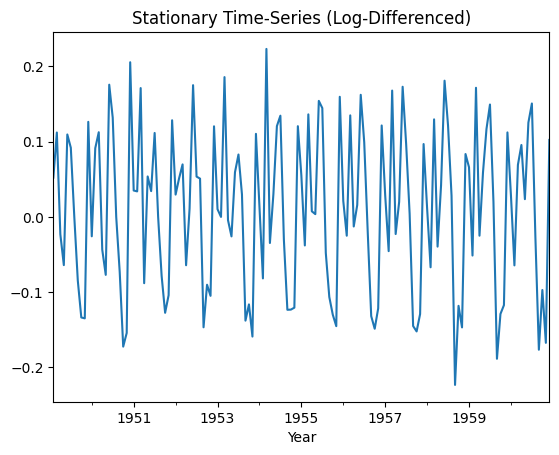

Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [12]:
##STEP 5 : MAKE DATA STATIONARY (means the mean,variance,autocorrelation are constant over time)
#Apply Log Transformation
time_df_log = np.log(time_df['Passengers'])

#Apply differencing to remove the trends
time_df_diff = time_df_log.diff().dropna()

#Plot the stationary series
time_df_diff.plot()
plt.title('Stationary Time-Series (Log-Differenced)')
plt.xlabel('Year')
plt.show()

#Retest Stationarity
test_stationarity(time_df_diff)

In [13]:
##OBSERVATION : After Retesting for ADF the p-value has come out to be 0.07 which is very small therefore we can reject the NULL HYPOTHESIS and accept the ALTERNATE HYPOTHESIS.

C:\Users\Admin\AppData\Local\Temp\ipykernel_8556\2188088386.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


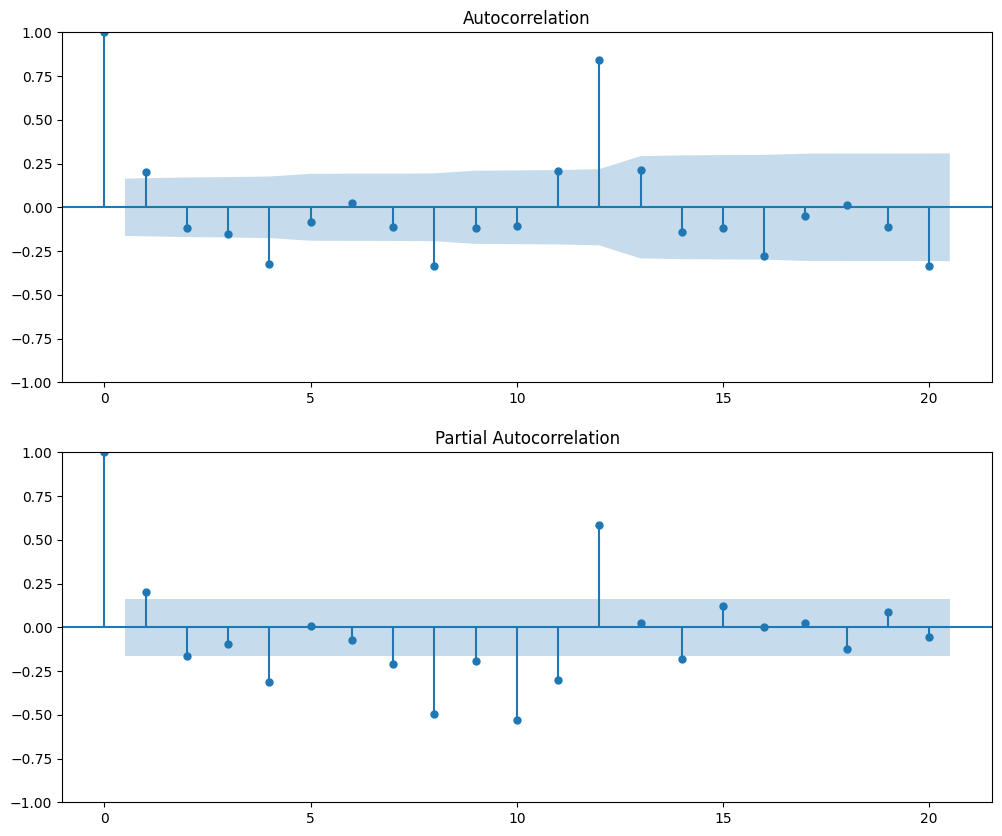

In [14]:
## Step 6 : ACF and PACF PLOTS
fig , axes = plt.subplots(2,1,figsize=(12,10))
plot_acf(time_df_diff,axes[0],lags=20)
plot_pacf(time_df_diff,axes[1],lags=20)
fig.show()

In [15]:
##OBSERVATION: ARIMA MODEL is characterized by 3 values - ARIMA(p,d,q) : 
# - The `d` term is the number of times we differenced the data (in our case, `d=1`).
# - The `p` (AR term) is suggested by the number of significant lags in the **PACF** plot.
# - The `q` (MA term) is suggested by the number of significant lags in the **ACF** plot.
#   Here,
# - PACF Plot: Cuts off sharply after lag 1. This suggests `p=1`.
# - ACF Plot: Also seems to cut off after lag 1. This suggests `q=1`.
# Based on this, a good starting point for our model is **ARIMA(1, 1, 1).

C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


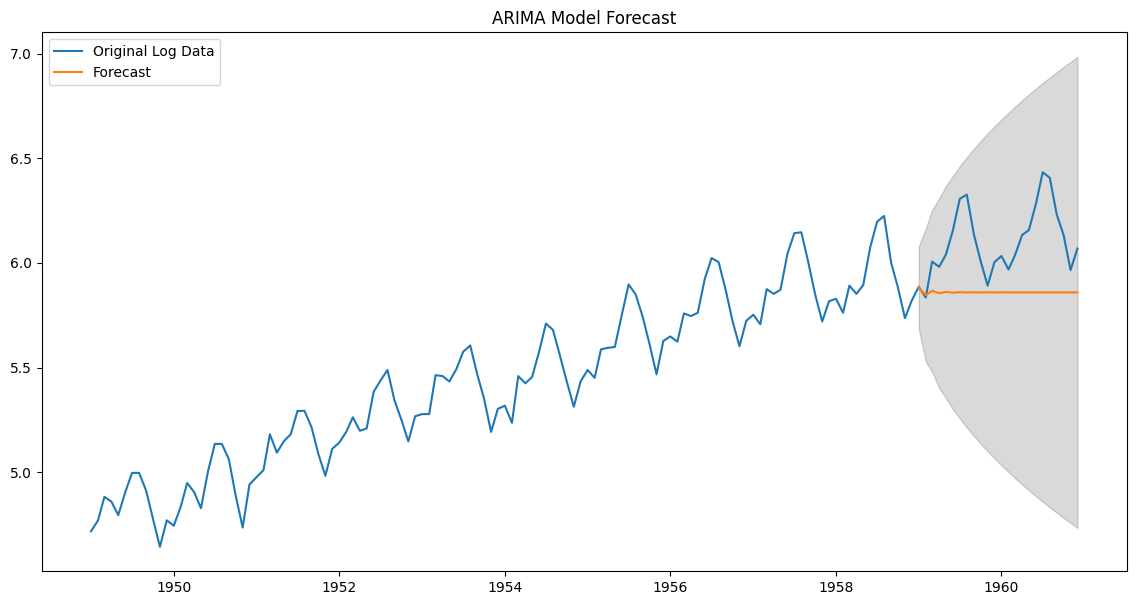

In [16]:
## Step 7 : ARIMA MODEL BUILDING
train_data = time_df_log[:'1958'] 
test_data = time_df_log['1959':]

model = ARIMA(train_data,order=(1,1,1),freq='MS')
result = model.fit()

forecast = result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

plt.figure(figsize=(14,7))
plt.plot(time_df_log,label='Original Log Data')
plt.plot(forecast.predicted_mean,label='Forecast')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:,0], ##all rows but first column
                 forecast_ci.iloc[:,1], ##all rows but second column
                 color='k',alpha=0.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

In [17]:
##OBSERVATION : The model captures the overall trend but completely misses the seasonal pattern. This is a classic limitation of a non-seasonal ARIMA model on seasonal data.Hence we need SARIMA Model.
##SARIMA is characterized by (P,Q,D,m).
# `(P, D, Q, m)` are the seasonal parameters:
#     - P (seasonal AR order): The number of seasonal lagged observations included in the model.
#     - D (seasonal differencing order): The number of times the data is differenced seasonally to remove seasonal trend.
#     - Q (seasonal MA order): The number of seasonal lagged forecast errors included in the model.
#     - m (number of periods in a season): The number of time steps for a single seasonal period (e.g., `m=12` for monthly data with an annual seasonality, `m=4` for quarterly data)

C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


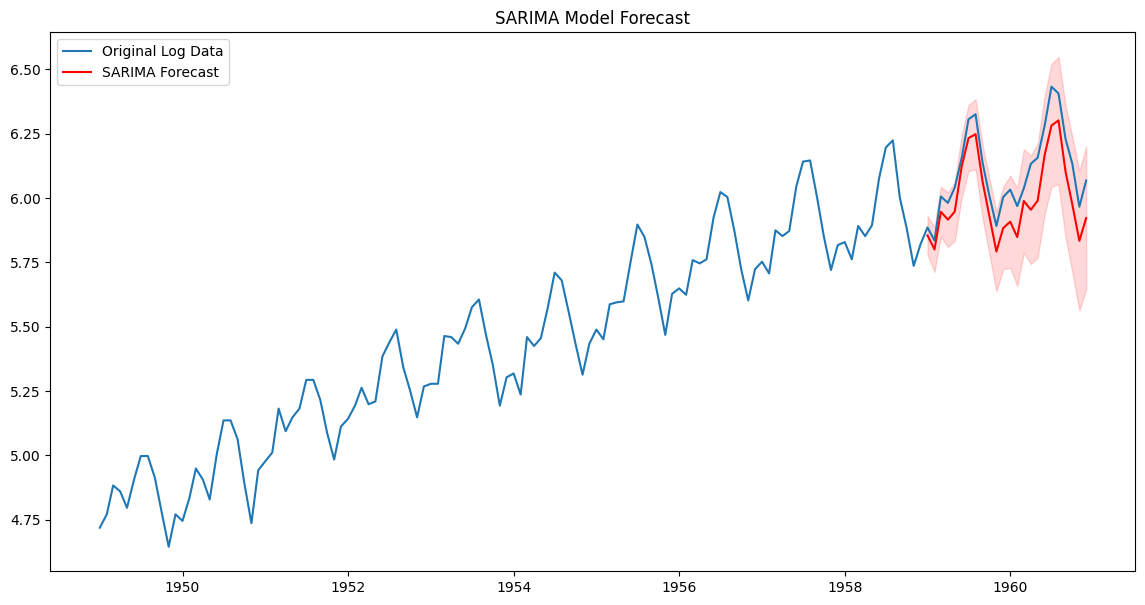

In [19]:
## Step 8 : SARIMA MODEL BUILDING
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS') # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(time_df_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

SARIMA Model RMSE: 48.27


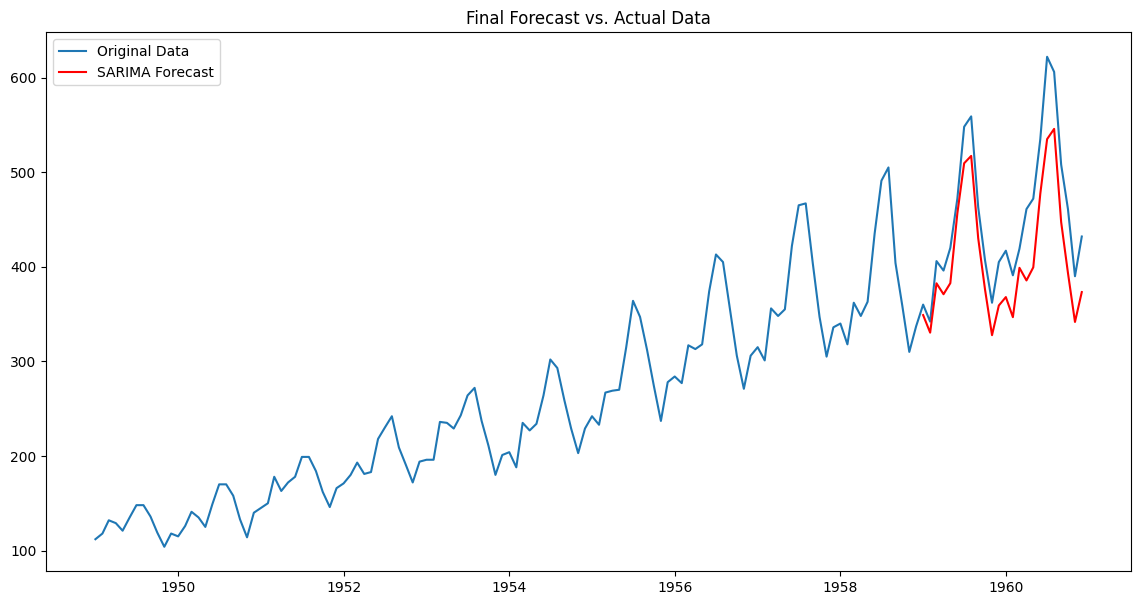

In [20]:
## Step 9 : MODEL EVALUATION
original_test_data = np.exp(test_data)
sarima_predictions = np.exp(sarima_forecast.predicted_mean)

# Calculate RMSE
rmse = root_mean_squared_error(original_test_data, sarima_predictions)
print(f"SARIMA Model RMSE: {rmse:.2f}")

# Plot final results
plt.figure(figsize=(14, 7))
plt.plot(time_df['Passengers'], label='Original Data')
plt.plot(sarima_predictions, label='SARIMA Forecast', color='red')
plt.title('Final Forecast vs. Actual Data')
plt.legend()
plt.show()
